In [1]:
# Load packages
import pandas as pd
import numpy as np
import cv2 as cv

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import time

## Linear SVC on full RGB images

Lets do a fit of thet test vectors, without any mapping. 

**Load train data**

In [6]:
train_df = pd.read_csv('output_rgb.csv')

#train_data = train_df.iloc[:, :train_df.shape[1]].values.astype(np.float32)
train_data = train_df.iloc[:, 1:].values.astype(np.float32)

train_target = train_df['label'].values

In [7]:
x_train = train_data
y_train =train_target

**Brief Sanity Check**

In [8]:
x_train.shape, train_df.shape

((3377, 14400), (3377, 14401))

In [9]:
pd.DataFrame(train_data).head(2), pd.DataFrame(train_target).head(2)

(   0      1      2      3      4      5      6      7      8      9      ...  \
 0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  ...   
 1  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  ...   
 
    14390  14391  14392  14393  14394  14395  14396  14397  14398  14399  
 0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  
 1  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  
 
 [2 rows x 14400 columns],
    0
 0  0
 1  2)

**Load test data**

**the following file has been superseded by 'gray_small_test_set.csv'. I changed the file name to a more descriptive name.**

In [10]:
test_df = pd.read_csv('output_rgb_test.csv')

test_data = test_df.iloc[:, 1:].values.astype(np.float32)

test_target = test_df['label'].values

In [11]:
x_test = test_data
y_test =  test_target

**Fit to train data**(took 12 minutes)

In [13]:
#1:39pm
# Classification with a linear SVM
percent=100
start_time = time.time()
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(x_train, y_train)
print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=True)



percent complete:  100 - 818.0988302230835 seconds -


**Test data**

In [20]:
start_time = time.time()
print("Accuracy on the test set with unprocessed RGB data: {:.3f}".format(clf.score(x_test, y_test)))
print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=True)

Accuracy on the test set with unprocessed RGB data: 0.984
percent complete:  100 - 0.2915217876434326 seconds -


**The accuracy is very high. We will explore if we can improve results with UMAP. We will also check if grayscale images yield the same results but with better performance**

**For later use**

In [15]:
import pickle

# Save to file
with open('linear_svc_raw_rgb_data.pkl', 'wb') as f:
    pickle.dump(clf, f)


In [16]:
# Load from file
with open('linear_svc_raw_rgb_data.pkl', 'rb') as f:
    clf_graw_loaded = pickle.load(f)

### Check accuracy per category 
Use test set

In [17]:
decipher_key = {
    0:"Pants",
    1:"Tshirts",
    2:"Watches",
    3:"Casual Shoes"
 
}

In [18]:
x_tlist =[]
y_tlist = []
tlabel =[]
for i in range(4):
    indices = np.where(y_test == i)[0]
    y_tlist.append(y_test[indices])
    x_tlist.append(x_test[indices])
    tlabel.append(decipher_key[i])
    
y_tlist[0].shape, y_tlist[0][0:3]
    

((239,), array([0, 0, 0], dtype=int64))

In [19]:
start_time = time.time()
for i in range(4):
    print("Accuracy on the",tlabel[i]," test set with raw RGB image: {:.3f}".\
          format(clf_graw_loaded.score(x_tlist[i], y_tlist[i])))
    
print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=True)

Accuracy on the Pants  test set with raw RGB image: 0.987
Accuracy on the Tshirts  test set with raw RGB image: 0.987
Accuracy on the Watches  test set with raw RGB image: 0.980
Accuracy on the Casual Shoes  test set with raw RGB image: 0.984
percent complete:  100 - 0.1172935962677002 seconds -


### Generate Confusion Matrix For Each Result

In [27]:
from sklearn.metrics import confusion_matrix
#x_tlist[i]
#y_tlist[i]

# Use the fitted model to make predictions on the same data used for fitting
y_pred = clf_graw_loaded.predict(x_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#print(cm)


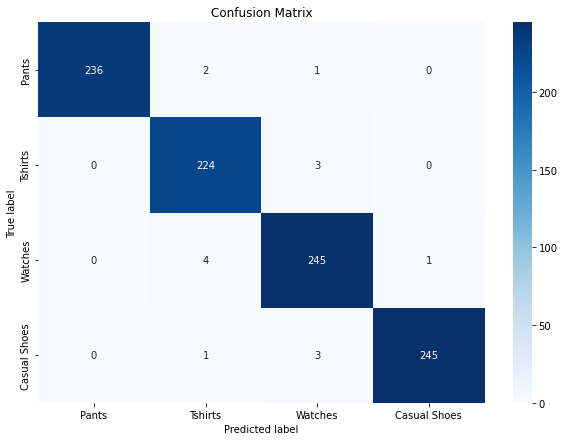

In [28]:
# Create a heatmap
# Create a list of labels
labels = [decipher_key[i] for i in range(4)]
plt.figure(figsize=(10,7))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Pull Up Examples of False Positives 

In [31]:
# Assuming y_true is your list of true labels and y_pred is your list of predicted labels
# And X_data is your original dataset

misclassified_indexes = []

for i in range(len(y_test)):
    # If true label is 'Tshirts' (which corresponds to 1)
    # and predicted label is 'Casual Shoes' (which corresponds to 3)
    if (y_test[i] == 1) and (y_pred[i] == 2):
        misclassified_indexes.append(i)

# Now, misclassified_indexes contains the indexes of all misclassified examples
# You can use it to get the corresponding data from X_data
#misclassified_data = x_test[misclassified_indexes]

In [32]:
misclassified_indexes

[225, 286, 910]

In [42]:
test_df = pd.read_csv('output_rgb_test.csv')

#test_img = test_df.iloc[:, 1:].values.astype(np.float32)
test_img = test_df.iloc[:, 1:].values.astype(np.uint8)

test_label = test_df['label'].values

#img_rgb = (img_rgb * 255).astype(np.uint8) before axarr.imshow(img_rgb)

<Figure size 2016x2016 with 0 Axes>

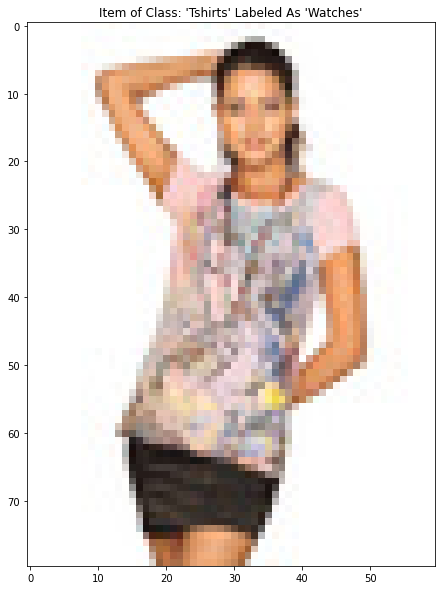

In [44]:
temp =misclassified_indexes[0]
img_rgb  = np.reshape(test_img[temp], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(1,1, figsize=(10, 10))
title = "Item of Class: \'" +decipher_key[test_label[temp]] +"\' Labeled As \'"+decipher_key[y_pred[temp]]+"\'"
axarr.title.set_text(title)
axarr.imshow(img_rgb)

<Figure size 2016x2016 with 0 Axes>

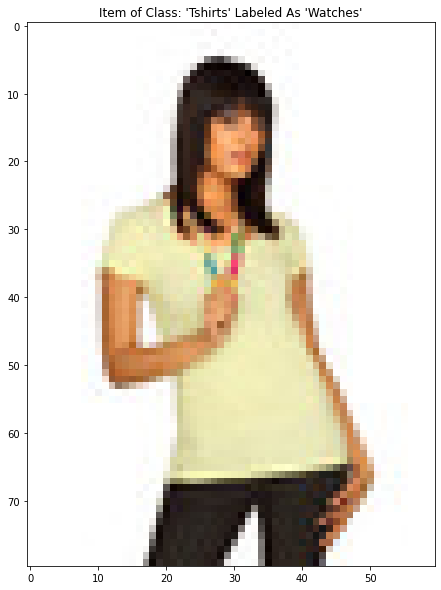

In [45]:
temp =misclassified_indexes[1]
img_rgb  = np.reshape(test_img[temp], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(1,1, figsize=(10, 10))
title = "Item of Class: \'" +decipher_key[test_label[temp]] +"\' Labeled As \'"+decipher_key[y_pred[temp]]+"\'"
axarr.title.set_text(title)
axarr.imshow(img_rgb)

<Figure size 2016x2016 with 0 Axes>

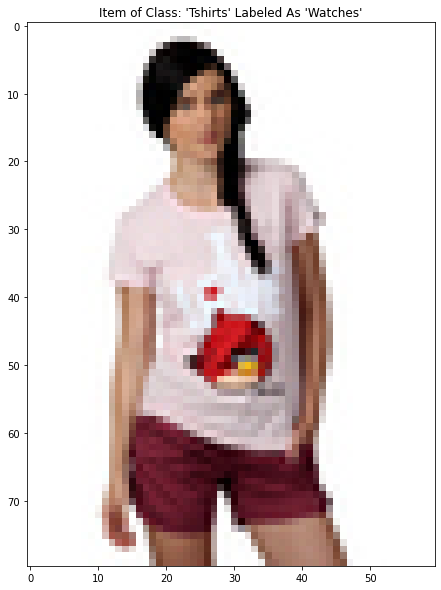

In [46]:
temp =misclassified_indexes[2]
img_rgb  = np.reshape(test_img[temp], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(1,1, figsize=(10, 10))
title = "Item of Class: \'" +decipher_key[test_label[temp]] +"\' Labeled As \'"+decipher_key[y_pred[temp]]+"\'"
axarr.title.set_text(title)
axarr.imshow(img_rgb)